In [2]:
import numpy as np
import matplotlib as mpl
print(mpl.__version__)
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
from scipy.special import erfinv, erf
pi=np.pi
m0 = 1.66*10**(-27) 
m = 40*m0
m_ev = m* 5.609e35
kb = 1.38*1e-23
T = 30 
ev = 1.6021766348*1e-19 
kbev = kb/ev
beta = 1./(kbev*T)
A = np.sqrt(beta/np.pi)

## - - - - - - - - - - - - - - - - - - - - - - - - - - -
##      plotting properties
## - - - - - - - - - - - - - - - - - - - - - - - - - - -

mpl.rcParams.update({
    "axes.autolimit_mode":"round_numbers",
    "axes.axisbelow":"False",
    "axes.edgecolor":"000000",
    "axes.facecolor":"FFFFFF",
    "axes.formatter.limits":"-2, 4",
    "axes.formatter.use_mathtext":"True",
    "axes.grid":"False",
    "axes.labelcolor":"000000",
    "axes.labelsize":"12",
    "axes.linewidth":"1",
    "axes.titlesize":"12",
    "axes.xmargin":"0.",
    "axes.ymargin":"0.",
    "errorbar.capsize":"1",
    "figure.autolayout":"True",
    "figure.dpi":"96",
    "figure.edgecolor":"0.50",
    "figure.facecolor":"FFFFFF",
    "figure.figsize":"6, 4.5",
    "font.family":"monospace",
    "font.size":"12",
    "legend.fancybox":"True",
    "legend.framealpha":"0.25",
    "legend.frameon":"True",
    "lines.markersize":"6",
    "savefig.dpi":"150",
    "savefig.facecolor":"FFFFFF00",
    "xtick.bottom":"True",
    "xtick.color":"000000",
    "xtick.direction":"in",
    "xtick.major.size":"10",
    "xtick.minor.size":"5",
    "xtick.top":"True",
    "ytick.color":"000000",
    "ytick.direction":"in",
    "ytick.left":"True",
    "ytick.major.size":"10",
    "ytick.minor.size":"5",
    "ytick.right":"True",
})


3.6.3


In [3]:
def few(x,beta=beta):
    #PDF for potential energy
    return np.sqrt(beta/(pi*x+1e-31))*np.exp(-beta*x)

def FEW(x,beta=beta):
    #primitive
    return erf(np.sqrt(beta*x))

def inverse_generator(invF,nObs=1,nExp=1, ethr=None):
    #inverse generator
    
    # Initialize generator
    rSeed=np.random.default_rng()
    
    if ethr is not None:
        x_good = np.array([])
        ii=0
        while x_good.shape[0] < n_exp*n_obs:

            # Generate everything together
            x_gen=invF(rSeed.uniform(size=(nObs*nExp - x_good.shape[0])))
            x_good = np.hstack([x_good,x_gen[x_gen<ethr]]) 

            ii+=1
            print('ITERATION:',ii)
    else:
        x_good=invF(rSeed.uniform(size=(nObs*nExp)))
    
    
    result=x_good.reshape( (n_exp,(int(x_good.shape[0]/n_exp))))
    
    return result

def logspace(nx,beta=beta,nsigma=10,minpow=-8):
    '''
    Define bin centers on which to evaluate the pdf
    considering that 1./beta is the scale of interest
    and that the sigma is ~1./(sqrt(2)*beta)
    '''
    sigma=1./(np.sqrt(2)*beta)
    return np.logspace(minpow,np.log10(sigma*nsigma),nx+2)






In [4]:
n_exp=1000
n_obs=10000
inv_cdf=lambda x, beta=beta: (1./beta)*(erfinv(x))**2
mc_data=inverse_generator(inv_cdf,nObs=n_obs,nExp=n_exp)

In [5]:
samp=mc_data[0]
print(samp)
mu=0.5/beta

[0.00034446 0.00051771 0.00090211 ... 0.0030645  0.00028784 0.000404  ]


In [6]:
def gauss(x,mu=0,sigma=1):
    ''' Gaussian pdf'''
    return (1./(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/(sigma))**2)



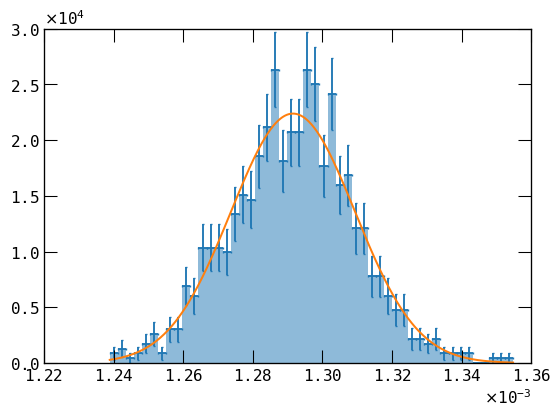

In [7]:
xbar=np.mean(mc_data,axis=1)

nbins=50
hist = np.histogram(xbar,bins=nbins)
binc = np.array([ (hist[1][i+1]+hist[1][i])*0.5 for i in range(len(hist[0])) ])
xerr = np.array([ (hist[1][i+1]-hist[1][i])*0.5 for i in range(len(hist[0])) ])
yerr = np.sqrt(hist[0])
norm = hist[0].sum()*xerr*2

xpts=np.linspace(hist[1][0],hist[1][-1],1000)

plt.hist(xbar,bins=nbins,density=True,alpha=.5)
plt.errorbar(binc, hist[0]/norm, xerr=xerr, yerr=yerr/norm,fmt='.',ms=0,lw=1.4, color='tab:blue',alpha=1)

# probably we could obtain the parameters from a fit
plt.plot(xpts,gauss(xpts,xbar.mean(),xbar.std()))

In [8]:
# Generate data
n_exp=500
n_obs=10000
mc_data=inverse_generator(inv_cdf,nObs=n_obs,nExp=n_exp)

In [9]:
def get_bin_val(hist,F=FEW):
   
    exp_vals=[]
    for i in range(len(hist[0])):
        int_fraction = F(hist[1][i+1]) - F(hist[1][i]) 
        exp_vals.append(int_fraction*hist[0].sum())
    return np.array(exp_vals)



In [10]:
nbins=[4,16,32]
chi_square=[]

# Looping over the bins
for n in nbins:
    chis=[]
    # Looping over the experiments
    for samp in mc_data:
        hist=np.histogram(samp,bins=n,range=(1e-9,0.02))
        nominal=get_bin_val(hist)

        # Assuming that the bin content is a poisson distribution
        # getting chi squared
        sigma2=nominal
        chis.append(np.sum(((hist[0]-nominal)**2)/sigma2))
    chi_square.append(chis)
chi_square=np.array(chi_square)

Text(0, 0.5, 'normalized counts')

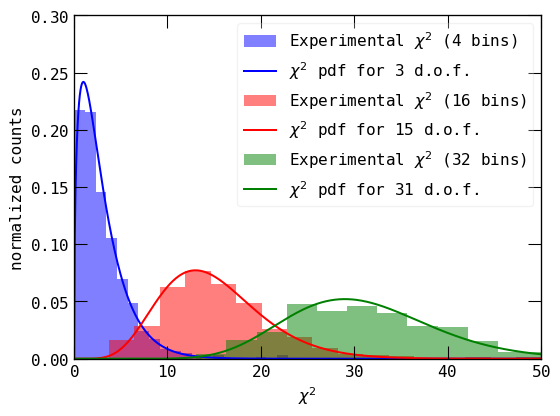

In [11]:
x=np.linspace(0,chi_square.max(),1000)
colors=['b','r','g']

for i, chiS in enumerate(chi_square):
    plt.hist(chiS, bins=20,density=True,alpha=0.5,color=colors[i],
             label='Experimental $\chi^2$ (%s bins)'%(nbins[i]));
    plt.plot(x,stats.chi2.pdf(x,df=nbins[i]-1), c=colors[i],
             label='$\\chi^{2}$ pdf for %d d.o.f.'%(nbins[i]-1))
    #plt.yscale('log')
plt.ylim(0,.3)
plt.xlim(0,50)
plt.legend()
plt.xlabel('$\\chi^{2}$')
plt.ylabel('normalized counts')

In [14]:
n_exp=1
n_obs=10000
mc_data=inverse_generator(inv_cdf,nObs=n_obs,nExp=n_exp)  

In [15]:
def logL(x,f=few,*params):
    # compute the probabilities according to the pdf
    # and return the sum of the log
    return -(np.log(f(x,*params))).sum()
def PEst(LL,xrange,delta=0.5):
   
    #Scale LL
    sLL=LL-LL.min()

    # Best parameter 
    imin=sLL.argmin()
    p=xrange[imin]

    # Estimate error by checking when sLL is equal to 0.5
    err_minus = np.interp(delta,np.flip(sLL[:imin]),np.flip(xrange[:imin]))
    err_plus  = np.interp(delta,sLL[imin:],xrange[imin:])
    err = (err_plus - err_minus)*0.5
    
    return p, err 

In [16]:
samp=mc_data[0]

# Compute the logLikelihood for a range of T
LogL = []
T_range=np.linspace(25,35,1000)
for i in T_range:
    LogL.append(logL(samp,few,1./(i*kbev)))
LogL=np.array(LogL)
print(LogL)

[-58399.93691546 -58400.3822732  -58400.82647394 -58401.2695194
 -58401.71141127 -58402.15215125 -58402.59174106 -58403.03018238
 -58403.4674769  -58403.90362632 -58404.33863233 -58404.77249661
 -58405.20522084 -58405.6368067  -58406.06725587 -58406.49657001
 -58406.92475081 -58407.35179992 -58407.77771901 -58408.20250974
 -58408.62617377 -58409.04871275 -58409.47012835 -58409.8904222
 -58410.30959595 -58410.72765126 -58411.14458975 -58411.56041307
 -58411.97512286 -58412.38872074 -58412.80120835 -58413.2125873
 -58413.62285924 -58414.03202577 -58414.44008853 -58414.84704911
 -58415.25290914 -58415.65767022 -58416.06133397 -58416.46390199
 -58416.86537587 -58417.26575722 -58417.66504764 -58418.06324872
 -58418.46036204 -58418.85638921 -58419.25133179 -58419.64519138
 -58420.03796956 -58420.4296679  -58420.82028797 -58421.20983135
 -58421.59829961 -58421.98569432 -58422.37201703 -58422.75726931
 -58423.14145271 -58423.5245688  -58423.90661912 -58424.28760523
 -58424.66752867 -58425.0463

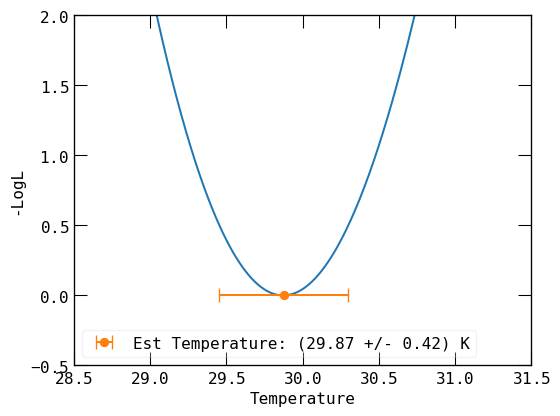

In [49]:
TEst, TErr=PEst(LogL,T_range)


plt.plot(T_range,LogL-LogL.min())
plt.errorbar(TEst,0.,xerr=TErr,fmt='o',ms=6, capsize=5,
            label='Est Temperature: (%.2f +/- %.2f) K'%(TEst,TErr))
plt.ylabel('-LogL')
plt.xlabel('Temperature')
plt.xlim(28.5,31.5)
plt.ylim(-0.5,2)
plt.legend();

In [50]:
# Create the distribution
nbins=50
hrange=logspace(100)
hist=np.histogram(samp,bins=hrange)
# Compute goodness of a fit for various T
T_range=np.linspace(20,50,1000)
chi_square=[]

for t in T_range:
    exp_val=get_bin_val(hist,lambda x : FEW(x,1./(t*kbev)))
    chi_square.append(((hist[0]-exp_val)**2/(exp_val*(1-(exp_val/hist[0].sum())))).sum())
chi_square=np.array(chi_square)

chi_square2=[]
for t in T_range:
    exp_val=(hist,lambda x : FEW(x,1./(t*kbev)))
    chi_square2.append(
        np.sum(
            ((samp.mean() - 0.5*kbev*t)/(samp.std()))**2
        )
    )
chi_square2=np.array(chi_square2)

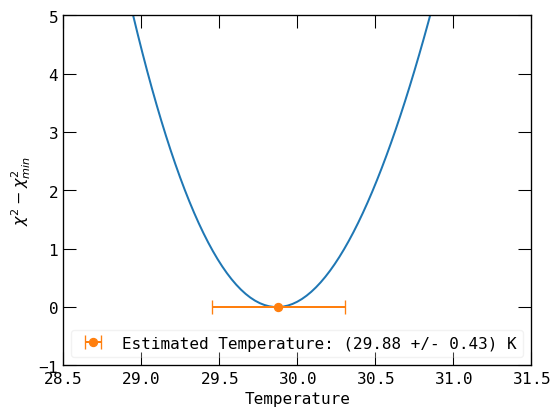

In [51]:

TEstb, TErrb=PEst(chi_square,T_range,1)

y_chi=chi_square-chi_square.min()
plt.plot(T_range,y_chi)
plt.errorbar(TEstb,y_chi.min(),xerr=TErrb,fmt='o',ms=6, capsize=5,
            label='Estimated Temperature: (%.2f +/- %.2f) K'%(TEstb,TErrb))

plt.ylabel('$\\chi^2 - \\chi^2_{min}$')
plt.xlabel('Temperature')
plt.xlim(28.5,31.5)
plt.ylim(-1,5)
plt.legend()

In [52]:

T_estc = 2*samp.mean()/kbev
T_errc = 2*samp.std()/(kbev*np.sqrt(samp.shape[0]))
print('Estimated Temperature: (%.2f +/- %.2f) K'%(T_estc,T_errc))

Estimated Temperature: (29.87 +/- 0.42) K


In [53]:
def plot_T(t,terr,nm, ms=8):
    return plt.errorbar(t, nm, xerr=terr, fmt='o',ms=ms, color='b', capsize=5, elinewidth=3, capthick=2)

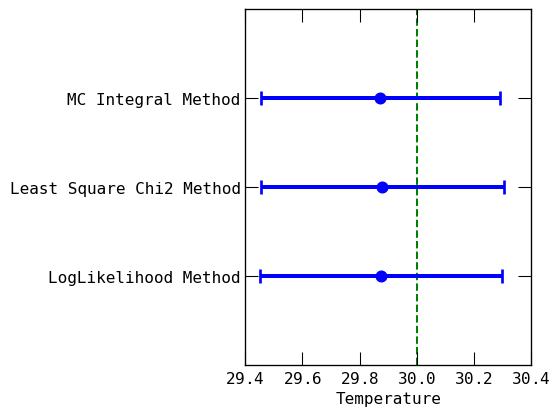

In [54]:
labels=[
    'LogLikelihood Method',
    'MC Integral Method',
    'Least Square Chi2 Method'
    
]

plt.plot([30,30],[0,4],'--',c='g')
plot_T(TEst, TErr,1)
plot_T(TEstb, TErrb,2)
plot_T(T_estc, T_errc,3)
plt.yticks([1,3,2],labels=labels)
plt.xlabel('Temperature');

In [71]:
n_exp=200
n_obs=10000
mc_data=inverse_generator(inv_cdf,nObs=n_obs,nExp=n_exp)
pairs=mc_data.flatten().reshape((int(n_exp/2),2,n_obs))
print(pairs)

[[[3.51547107e-04 3.60332852e-03 2.92800241e-04 ... 5.68172716e-05
   5.07086564e-04 5.76300052e-04]
  [4.73370251e-04 1.33401791e-03 4.85088581e-04 ... 6.14455623e-05
   3.13612683e-07 5.91415277e-04]]

 [[6.24064338e-04 8.37273584e-05 2.72302627e-03 ... 7.91838791e-05
   4.60584979e-04 2.94198161e-04]
  [5.22410035e-03 7.86842499e-04 5.46366042e-05 ... 7.31583388e-04
   3.56735405e-04 1.31022367e-02]]

 [[1.11938785e-04 4.35553535e-04 3.85148258e-03 ... 1.40508866e-03
   6.75074404e-04 5.90999825e-04]
  [6.45225943e-04 1.49505813e-05 7.37295558e-05 ... 2.94388760e-03
   1.66985231e-03 3.75637168e-04]]

 ...

 [[1.25128120e-02 7.34662728e-04 2.69335478e-04 ... 1.55518370e-03
   3.99659901e-04 2.23783641e-03]
  [3.82681633e-04 4.38002617e-04 3.07842314e-03 ... 1.89469848e-03
   1.10498720e-04 1.18390829e-06]]

 [[1.00472823e-03 5.29623392e-04 2.61819684e-03 ... 3.22885208e-03
   2.30348248e-04 4.23092961e-03]
  [2.34014646e-03 3.23086290e-03 3.51330482e-04 ... 2.46682404e-04
   7.42577

In [72]:
def get_log_cumk(x,npt=10):
    bins=logspace(npt)
    h=np.histogram(x,bins=bins)
    cumk=np.cumsum(h[0])/h[0].sum()
    return cumk, h[1]

d=[]
npt=10_000

for p in pairs:
    
   
    y1,_1=get_log_cumk(p[0],npt)
    y2,_2=get_log_cumk(p[1],npt)
    
    
    D=np.max(np.abs(y1-y2))
    d.append(D*np.sqrt(n_obs/2))

d=np.array(d)
print(d)

[0.78199692 0.80566811 1.52141065 0.86875999 0.55175809 0.9265476
 1.26234536 1.02312539 0.72556023 1.22209002 0.46753052 0.71895191
 0.95930991 1.04995215 0.77984506 0.90500591 0.73421981 0.49626504
 1.08974235 1.02459867 1.00031144 0.80969918 1.03750526 0.64554354
 0.7554582  0.95881504 0.77045392 0.8332265  0.87688822 0.89660824
 0.96574245 0.63998498 1.46679331 0.69385488 0.80865329 0.91002851
 0.79922738 0.8078068  0.51041346 0.70175467 0.72999996 0.63775938
 0.60917016 0.70807467 0.99841208 1.0543899  1.49468574 0.84116271
 0.73954298 0.49347198 1.16814    0.7900525  1.61450279 1.14129516
 0.92517915 0.91936539 1.24980068 1.17238935 0.67669417 0.83448941
 0.46908302 0.78765704 0.8743073  0.79798563 0.64226847 0.66674729
 0.75383762 0.80056243 0.4475309  0.72965734 0.60152186 0.84023899
 1.3180823  0.77968871 0.93678524 1.27004799 0.74368101 1.25333149
 0.47531353 0.95344927 0.57617732 0.65065052 0.8412186  0.53034609
 1.28291972 1.59433837 1.08072147 0.80627835 0.87518741 0.65608

Text(0, 0.5, 'Normalized Entries')

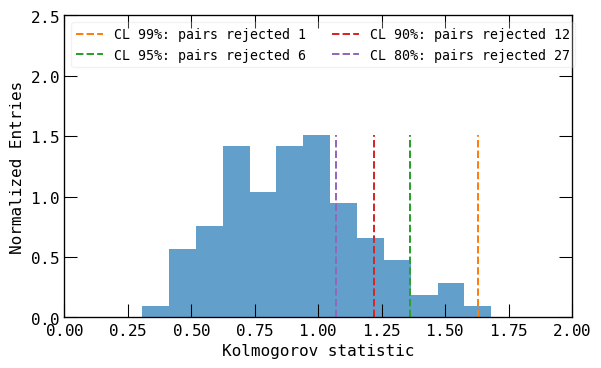

In [70]:


fig = plt.figure(figsize=(6.5,4))
h=plt.hist(d,bins=np.linspace(0.2,2,18), density=True,alpha=0.7)

#Dictionary of tabulated significance levels
wp_dict={ 
    '99%': 1.63,
    '95%': 1.36,
    '90%': 1.22,
    '80%': 1.07,
}

# Loop over wp and comput the rejected pairs of sample
for wp, cut in wp_dict.items():
    comp=d[d>cut].shape[0]
    plt.plot([cut,cut],[0,max(h[0])],'--', 
             label=f'CL {wp}: pairs rejected {comp}')
plt.legend(ncol=2, loc='upper left', prop={'size': 10})
plt.ylim(0,2.5)
plt.xlabel('Kolmogorov statistic')
plt.ylabel('Normalized Entries')
